In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
print(torch.__version__)
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms as T
import random
import cv2
import numpy as np
!pip install pyefd
import pyefd
from google.colab.patches import cv2_imshow
!pip install cairocffi
import cairocffi as cairo
import struct
from struct import unpack
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

1.12.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.9 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89668 sha256=d2f92b3fc389348355347623e6dd4b84d944f0c9a47b10c76135d6f2a2323b88
  Stored in directory: /root/.cache/pip/wheels/4e/ca/e1/5c8a9692a27f639a07c949044bec943f26c81cd53d3805319f
Successfully built cairocffi
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 8.6 MB/s 
     |████████████████████████████████| 3.5 MB 54.5 MB/s 
     |████████████████████████████████| 2.4 MB 35.2 MB/s 
     |████████████████████████████████| 709 kB 51.0 MB/s 
     |████████████████████████████████| 467 

In [ ]:
# Env vars
torch.use_deterministic_algorithms(False)

# Const vars
LOAD_PATH = '/content/drive/My Drive/Fourier/Saved Models/GNN allF10-001 wide-deep.pt'
RAND_SEED = 0
DEVICE = "cpu"
IMG_SIDE = 28
NUM_CLASSES = 343
EPOCHS = 10
BATCH_SIZE = 500
LOSS_FN = nn.CrossEntropyLoss()
EDGE_ATTR_DIM = 3

In [ ]:
# convert raw vector image to list of raster images, one for each stroke
def vector_to_raster(vector_image, side=IMG_SIDE, line_diameter=16, padding=96, bg_color=(0,0,0), fg_color=(1,1,1)):
  """
  padding and line_diameter are relative to the original 256x256 image.
  """
  
  original_side = 256.
  
  surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, side, side)
  ctx = cairo.Context(surface)
  ctx.set_antialias(cairo.ANTIALIAS_BEST)
  ctx.set_line_cap(cairo.LINE_CAP_ROUND)
  ctx.set_line_join(cairo.LINE_JOIN_ROUND)
  ctx.set_line_width(line_diameter)

  # scale to match the new size
  # add padding at the edges for the line_diameter
  # and add additional padding to account for antialiasing
  total_padding = padding * 2. + line_diameter
  new_scale = float(side) / float(original_side + total_padding)
  ctx.scale(new_scale, new_scale)
  ctx.translate(total_padding / 2., total_padding / 2.)
      
  bbox = np.hstack(vector_image).max(axis=1)
  offset = ((original_side, original_side) - bbox) / 2.
  offset = offset.reshape(-1,1)
  centered = [stroke + offset for stroke in vector_image]

  stroke_rasters = []
  for xv, yv in centered:
    # clear background
    ctx.set_source_rgb(*bg_color)
    ctx.paint()

    # draw strokes, this is the most cpu-intensive part
    ctx.set_source_rgb(*fg_color)        
    ctx.move_to(xv[0], yv[0])
    for x, y in zip(xv, yv):
        ctx.line_to(x, y)
    ctx.stroke()

    data = surface.get_data()
    stroke_raster = np.copy(np.asarray(data)[::4]).reshape(28, 28)
    stroke_rasters.append(stroke_raster)

  return stroke_rasters

def get_edges(stroke_angles, stroke_centers, stroke_rasters): 
  adj_1 = []
  adj_2 = []
  edge_info = []
  ANGLE_NORM = 2*np.pi
  DIST_NORM = np.sqrt(IMG_SIDE**2 + IMG_SIDE**2)
  for i in range(len(stroke_angles)):
      values=np.nonzero(stroke_rasters[i])
      for j in range(i+1,len(stroke_angles)):
          ij_info = []
          ji_info = []
          adj_1.append(i)
          adj_2.append(j)
          adj_1.append(j)
          adj_2.append(i)
          
          angle_diff_ij = stroke_angles[i] - stroke_angles[j]
          angle_diff_ji = stroke_angles[j] - stroke_angles[i]
          angle_diff_norm_ij = [angle_diff_ij / ANGLE_NORM]
          angle_diff_norm_ji = [angle_diff_ji / ANGLE_NORM]
          ij_info.append(angle_diff_norm_ij)
          ji_info.append(angle_diff_norm_ji)

          dist = np.sqrt((stroke_centers[i][0] - stroke_centers[j][0])**2 +
                         (stroke_centers[i][1] - stroke_centers[j][1])**2)
          dist_norm = [dist / DIST_NORM]
          ij_info.append(dist_norm)
          ji_info.append(dist_norm)

          connected = False
          for k in range(len(values[0])):
              x=values[0][k]
              y=values[1][k]
              sum = stroke_rasters[j][x][y]

              if x != 0 and y != 0:
                sum += stroke_rasters[j][x-1][y-1]
              if y != 0:
                sum += stroke_rasters[j][x][y-1]
              if x != 27 and y != 0:
                sum += stroke_rasters[j][x+1][y-1] 
              if x != 27:
                sum += stroke_rasters[j][x+1][y]
              if x != 27 and y != 27:
                sum += stroke_rasters[j][x+1][y+1] 
              if y != 27:
                sum += stroke_rasters[j][x][y+1] 
              if x != 0 and y != 27:
                sum += stroke_rasters[j][x-1][y+1]
              if x != 0:
                sum += stroke_rasters[j][x-1][y]
              
              if sum != 0:
                connected = True
                break
          if connected:
            ij_info.append([1])
            ji_info.append([1])
          else:
            ij_info.append([0])
            ji_info.append([0])
          
          edge_info.append(ij_info)
          edge_info.append(ji_info)

  edge_indices = torch.LongTensor([adj_1,adj_2])
  edge_attr = torch.FloatTensor(edge_info)
  return edge_indices, edge_attr

means = np.asarray([[1.00000000e+00,  8.64704953e-20,  4.23785772e-20, -5.55188263e-01],
 [-4.21131398e-03, -8.73318590e-04, -7.46787944e-03, -1.16146910e-02],
 [ 3.45495835e-02, -2.98804448e-04,  1.64286745e-04, -5.45286175e-02],
 [-5.87583192e-06, -2.53474884e-04, -6.50432941e-05,  3.94554346e-03],
 [ 5.82578165e-03, -6.83578601e-04,  1.32397937e-04, -7.64260417e-03],
 [ 3.16973027e-05, -1.02179629e-04, -3.79339444e-04, -4.74683571e-04],
 [ 1.34949896e-03, -1.36386428e-04,  1.15424560e-04, -1.54791375e-03],
 [ 6.86240768e-05, -5.95330926e-05,  3.42253351e-05,  5.09141139e-04],
 [ 1.14870610e-03, -4.14005821e-05,  2.85670771e-05, -5.24566362e-04],
 [ 1.22019705e-04, -8.23679948e-05, -9.08114311e-05, -8.45407870e-05]])

stdevs = np.asarray([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 2.28322956e-01],
 [1.23763294e-01, 1.30004807e-01, 2.44674213e-01, 1.36764044e-01],
 [8.84229438e-02, 6.22169306e-02, 7.98833353e-02, 8.84160503e-02],
 [4.84725535e-02, 4.71595999e-02, 5.60523362e-02, 5.11812694e-02],
 [3.88979383e-02, 3.34160340e-02, 3.58259993e-02, 3.86328886e-02],
 [2.44812410e-02, 2.43872982e-02, 2.82021738e-02, 2.67411865e-02],
 [1.97384502e-02, 1.81130527e-02, 2.00832990e-02, 2.08832311e-02],
 [1.45924819e-02, 1.45891669e-02, 1.58764064e-02, 1.52681562e-02],
 [1.22818532e-02, 1.17304880e-02, 1.22845295e-02, 1.25736286e-02],
 [9.61639517e-03, 9.74633403e-03, 1.03337422e-02, 1.01022058e-02]])

# transform functions - take sketch image, return torch tensor of descriptors
def fourier_transform(vector_img, is_test):
  stroke_rasters = vector_to_raster(vector_img)

  # add rotations and translations at test time
  if is_test: 
    stroke_rasters = np.stack(stroke_rasters)
    stroke_rasters = torch.from_numpy(stroke_rasters).float()

    angle = random.random()*60 - 30
    deltaX = random.randint(-3, 3)
    deltaY = random.randint(-3, 3)

    stroke_rasters = T.functional.affine(stroke_rasters,angle,[deltaX, deltaY],1,0,
                                          interpolation=T.InterpolationMode.BILINEAR)
    stroke_rasters = np.asarray(stroke_rasters)
    stroke_rasters = np.split(stroke_rasters, stroke_rasters.shape[0])
    stroke_rasters = [np.squeeze(a) for a in stroke_rasters]

  stroke_rasters_binary = []
  for raster in stroke_rasters:
    raster_binary = cv2.threshold(raster, 100, 255, cv2.THRESH_BINARY)[1]
    stroke_rasters_binary.append(raster_binary.astype(np.float32))

  stroke_fourier_descriptors = []
  strokes_to_remove = []
  stroke_angles = []
  stroke_centers = []
  for i, raster in enumerate(stroke_rasters_binary):
    contours = cv2.findContours(raster.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]

    largest_size = 0
    largest_index = 0
    for k, contour in enumerate(contours):
        if len(contour) > largest_size:
          largest_size = len(contour)
          largest_index = k

    if largest_size > 1:
      contour = contours[largest_index]
      coeffs, transform = pyefd.elliptic_fourier_descriptors(np.squeeze(contour), 
                                                          order=FOURIER_ORDER, 
                                                          normalize=True,
                                                          return_transformation=True)
      stroke_angle = transform[1]
      coeffs = (coeffs - means) / stdevs
      stroke_fourier_descriptors.append(coeffs.flatten())
      stroke_angles.append(stroke_angle)
      stroke_center = pyefd.calculate_dc_coefficients(np.squeeze(contour))
      stroke_centers.append(stroke_center)
    else:
      strokes_to_remove.append(i)

  for i in reversed(strokes_to_remove):
    del stroke_rasters_binary[i]

  edge_indices, edge_attr = get_edges(stroke_angles, stroke_centers,
                                      stroke_rasters_binary)
  stroke_fourier_descriptors = np.stack(stroke_fourier_descriptors)
  stroke_fourier_descriptors = torch.from_numpy(stroke_fourier_descriptors).float()
  return stroke_fourier_descriptors, edge_indices, edge_attr

# helper method to find class based on imgset index
def find_class(idx, num_list):
  class_id = 0
  sum = num_list[class_id]
  while idx >= sum:
    class_id += 1
    sum += num_list[class_id]
  return class_id

# deterministic worker re-seeding
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

# custom dataset for quickdraw
class QuickdrawDataset(Dataset):
  def __init__(self, imgs, nums, is_test):
    self.imgs = imgs
    self.nums = nums
    self.len = sum(nums)
    self.is_test = is_test

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    img = self.imgs[idx]
    x, edge_index, edge_attr = fourier_transform(img, self.is_test)
    y = find_class(idx, self.nums)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)


# pytorch-geometric GCN
class GCN(torch.nn.Module):
  def __init__(self):
    super(GCN, self).__init__()
    self.conv1 = GCNConv(FOURIER_ORDER * 4, 512)
    self.conv2 = GCNConv(512, 512)
    self.conv3 = GCNConv(512, 512)
    self.conv4 = GCNConv(512, 512)
    self.conv5 = GCNConv(512, 512)
    self.conv6 = GCNConv(512, 512)
    self.conv7 = GCNConv(128, 128)
    self.conv8 = GCNConv(128, 128)
    self.fc1 = nn.Linear(512, 768)
    self.fc2 = nn.Linear(768, 768)
    self.head = nn.Linear(768, NUM_CLASSES)
    self.edge_proj = nn.Linear(EDGE_ATTR_DIM, 1)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()


  def forward(self, data):
    x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

    if EDGE_ATTR_DIM > 1:
      edge_attr = edge_attr.squeeze(dim=2)
    edge_weight = self.edge_proj(edge_attr)
    edge_weight = self.sigmoid(edge_weight)
    x = self.conv1(x, edge_index, edge_weight)
    x = self.relu(x)
    x = self.conv2(x, edge_index, edge_weight)
    x = self.relu(x)
    x = self.conv3(x, edge_index, edge_weight)
    x = self.relu(x)
    x = self.conv4(x, edge_index, edge_weight)
    x = self.relu(x)
    x = self.conv5(x, edge_index, edge_weight)
    x = self.relu(x)
    x = self.conv6(x, edge_index, edge_weight)
    x = self.relu(x)
    # x = self.conv7(x, edge_index, edge_weight)
    # x = self.relu(x)
    # x = self.conv8(x, edge_index, edge_weight)
    # x = self.relu(x)
    x = global_mean_pool(x, batch)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    return self.head(x)


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # put the model in train mode
    total_loss = 0
    total_correct = 0
    # for each batch in the training set compute loss and update model parameters
    for batch, data in enumerate(dataloader):
      data = data.to(DEVICE)
      # Compute prediction and loss
      out = model(data)
      loss = loss_fn(out, data.y)

      # Backpropagation to update model parameters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # print current training metrics for user
      data, out, loss = data.to("cpu"), out.to("cpu"), loss.to("cpu")
      loss_val = loss.item()
      if batch % 100 == 0:
          current = (batch + 1) * BATCH_SIZE
          print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

      pred = out.argmax(dim=1, keepdim=True)
      correct = pred.eq(data.y.view_as(pred)).sum().item()
      total_correct += correct
      total_loss += loss_val
      # print(f"train loss: {loss_val:>7f}   train accuracy: {correct / BATCH_SIZE:>7f}   [batch: {batch + 1:>3d}/{(size // BATCH_SIZE) + 1:>3d}]")      
    print(f"\nepoch avg train loss: {total_loss / ((size // BATCH_SIZE) + 1):>7f}   epoch avg train accuracy: {total_correct / size:>7f}")
      
def eval_loop(dataloader, model):
  model.eval()
  size = len(dataloader.dataset)
  with torch.no_grad():
    total_correct = 0
    for data in dataloader:
      data = data.to(DEVICE)
      out = model(data)
      data, out = data.to("cpu"), out.to("cpu")
      pred = out.argmax(dim=1, keepdim=True)
      total_correct += pred.eq(data.y.view_as(pred)).sum().item()

    accuracy = total_correct / size
    print(f"test accuracy: {accuracy:>7f}")

In [ ]:
# define methods for unpacking Quickdraw .bin files
def unpack_drawing(file_handle):
  file_handle.read(15)
  n_strokes, = unpack('H', file_handle.read(2))
  image = []
  for i in range(n_strokes):
      n_points, = unpack('H', file_handle.read(2))
      fmt = str(n_points) + 'B'
      x = unpack(fmt, file_handle.read(n_points))
      y = unpack(fmt, file_handle.read(n_points))
      image.append((x, y))

  return image


def unpack_drawings(filename):
  imageset = []
  with open(filename, 'rb') as f:
      while True:
          try:
              imageset.append(unpack_drawing(f))
          except struct.error:
              break
  return imageset

train_dir = '/content/drive/My Drive/Fourier/Quickdraw Dataset Small/Train/'
test_dir = '/content/drive/My Drive/Fourier/Quickdraw Dataset Small/Test/'
train_imgs = []
test_imgs = []
train_nums = []
test_nums = []
list_of_classes = ["The Eiffel Tower", "The Great Wall of China", "The Mona Lisa",
                   "aircraft carrier", "airplane", "alarm clock", "ambulance", 
                   "angel", "ant", "anvil", "apple", "arm", "asparagus", "axe", 
                   "backpack", "banana", "bandage", "barn", "baseball bat", 
                   "baseball", "basket", "basketball", "bathtub", "beach", "bear", 
                   "beard", "bed", "bee", "belt", "bench", "bicycle", "binoculars", 
                   "bird", "birthday cake", "blackberry", "blueberry", "book", 
                   "boomerang", "bottlecap", "bowtie", "bracelet", "brain", 
                   "bread", "bridge", "broccoli", "broom", "bucket", "bulldozer", 
                   "bus", "bush", "butterfly", "cactus", "cake", "calculator", 
                   "calendar", "camel", "camera", "camouflage", "campfire", 
                   "candle", "cannon", "canoe", 'car', 'carrot', "castle", "cat", "ceiling fan", 
                   "cell phone", "cello", "chair", "chandelier", "church", 
                   "circle", "clarinet", "clock", "cloud", "coffee cup", 
                   "compass", "computer", "cookie", "cooler", "couch", "cow",
                   "crab", "crayon", "crocodile", "crown", "cruise ship", 
                   "cup", "diamond", "dishwasher", "diving board", "dog", 
                   "dolphin", "donut", "door", "dragon", "dresser", "drill", 
                   "drums", "duck", "dumbbell", "ear", "elbow", "elephant", 
                   "envelope", "eraser", "eye", "eyeglasses", "face", "fan",
                   "feather", "fence", "finger", "fire hydrant", "fireplace",
                   "firetruck", "fish", "flamingo", "flashlight", "flip flops", 
                   "floor lamp", "flower", "flying saucer", "foot", "fork", 
                   "frog", "frying pan", "garden hose", "garden", "giraffe", 
                   "goatee", "golf club", "grapes", "grass", "guitar", 
                   "hamburger", "hammer", "hand", "harp", "hat", "headphones", 
                   "hedgehog", "helicopter", "helmet", "hexagon", "hockey puck", 
                   "hockey stick", "horse", "hospital", "hot air balloon", 
                   "hot dog", "hot tub", "hourglass", "house plant", "house", 
                   "hurricane", "ice cream", "jacket", "jail", "kangaroo", 
                   "key", "keyboard", "knee", "knife", "ladder", "lantern", 
                   "laptop", "leaf", "leg", "light bulb", "lighter", "lighthouse",
                   "lightning", "line", "lion", "lipstick", "lobster", "lollipop",
                   "mailbox", "map", "marker", "matches", "megaphone", "mermaid", 
                   "microphone", "microwave", "monkey", "moon", "mosquito", 
                   "motorbike", "mountain", "mouse", "moustache", "mouth", "mug",
                   "mushroom", "nail", "necklace", "nose", "ocean", "octagon", 
                   "octopus", "onion", "oven", "owl", "paint can", "paintbrush", 
                   "palm tree", "panda", "pants", "paper clip", "parachute", 
                   "parrot", "passport", "peanut", "pear", "peas", "pencil", 
                   "penguin", "piano", "pickup truck", "picture frame", "pig", 
                   "pillow", "pineapple", "pizza", "pliers", "police car", 
                   "pond", "pool", "popsicle", "postcard", "potato", 
                   "power outlet", "purse", "rabbit", "raccoon", "radio", 
                   "rain", 'rainbow', 'rake', 'remote control', 'rhinoceros', 
                   'rifle', 'river', 'roller coaster', 'rollerskates', 
                   'sailboat', 'sandwich', 'saw', 'saxophone', 'school bus', 
                   'scissors', 'scorpion', 'screwdriver', 'sea turtle', 
                   'see saw', 'shark', 'sheep', 'shoe', 'shorts', 'shovel', 
                   'sink', 'skateboard', 'skull', 'skyscraper', 'sleeping bag', 
                   'smiley face', 'snail', 'snake', 'snorkel', 'snowflake', 
                   'snowman', 'soccer ball', 'sock', 'speedboat', 'spider', 
                   'spoon', 'spreadsheet', 'square', 'squiggle', 'squirrel', 
                   'stairs', 'star', 'steak', 'stereo', 'stethoscope', 'stitches', 
                   'stop sign', 'stove', 'strawberry', 'streetlight', 
                   'string bean', 'submarine', 'suitcase', 'sun', 'swan', 
                   'sweater', 'swing set', 'sword', 'syringe', 't-shirt', 
                   'table', 'teapot', 'teddy-bear', 'telephone', 'television', 
                   'tennis racquet', 'tent', 'tiger', 'toaster', 'toe', 'toilet', 
                   'tooth', 'toothbrush', 'toothpaste', 'tornado', 'tractor', 
                   'traffic light', 'train', 'tree', 'triangle', 'trombone', 
                   'truck', 'trumpet', 'umbrella', 'underwear', 'van', 'vase', 'violin', 
                   'washing machine', 'watermelon', 'waterslide', 'whale', 
                   'wheel', 'windmill', 'wine bottle', 'wine glass', 'wristwatch', 
                   'yoga', 'zebra', 'zigzag']

In [ ]:
# load dataset
for item in list_of_classes:
  train_folder = train_dir + item + '.bin'
  test_folder = test_dir + item + '.bin'
  train_drawings = unpack_drawings(train_folder)
  train_imgs += train_drawings
  train_nums.append(len(train_drawings))
  test_drawings = unpack_drawings(test_folder)
  test_imgs += test_drawings
  test_nums.append(len(test_drawings))

test accuracy: 0.213296


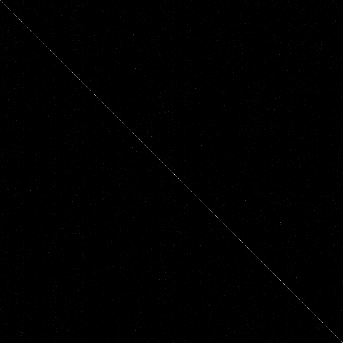

mouse accuracy 0.0
bird accuracy 0.0
dog accuracy 0.0
camouflage accuracy 0.0
rhinoceros accuracy 0.0
diving board accuracy 0.0
bottlecap accuracy 0.0
arm accuracy 0.0
garden hose accuracy 0.0
frog accuracy 0.0
megaphone accuracy 0.01
blackberry accuracy 0.01
hurricane accuracy 0.01
trombone accuracy 0.01
goatee accuracy 0.01
The Great Wall of China accuracy 0.01
asparagus accuracy 0.01
rifle accuracy 0.01
cooler accuracy 0.02
toilet accuracy 0.02
aircraft carrier accuracy 0.02
bulldozer accuracy 0.02
mosquito accuracy 0.02
bed accuracy 0.02
beard accuracy 0.02
laptop accuracy 0.02
snail accuracy 0.02
castle accuracy 0.02
raccoon accuracy 0.02
toothpaste accuracy 0.02
bear accuracy 0.02
nail accuracy 0.02
fork accuracy 0.03
truck accuracy 0.03
lobster accuracy 0.03
broccoli accuracy 0.03
floor lamp accuracy 0.03
elephant accuracy 0.03
blueberry accuracy 0.03
helicopter accuracy 0.04
pliers accuracy 0.04
fire hydrant accuracy 0.04
knife accuracy 0.04
cannon accuracy 0.04
lantern accurac

In [ ]:
FOURIER_ORDER = 10
DEVICE = "cpu"
torch.manual_seed(RAND_SEED)
random.seed(RAND_SEED)
g = torch.Generator()
g.manual_seed(RAND_SEED)

def get_confusion_mat(dataloader, model):
  model.eval()
  size = len(dataloader.dataset)
  conf_mat = np.zeros((343, 343))
  with torch.no_grad():
    total_correct = 0
    for data in dataloader:
      data = data.to(DEVICE)
      out = model(data)
      data, out = data.to("cpu"), out.to("cpu")
      pred = out.argmax(dim=1, keepdim=True)
      y = data.y.view_as(pred)
      total_correct += pred.eq(y).sum().item()
      y, pred = y.numpy(), pred.numpy()
      indices = np.concatenate((y, pred), axis=1)
      for i in range(indices.shape[0]):
        conf_mat[indices[i, 0], indices[i, 1]] += 1

    accuracy = total_correct / size
    print(f"test accuracy: {accuracy:>7f}")
    return conf_mat

eval_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
eval_loader = DataLoader(eval_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

model = GCN()
checkpoint = torch.load(LOAD_PATH, map_location=torch.device(DEVICE))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)

random.seed(RAND_SEED)
conf_mat = get_confusion_mat(dataloader=eval_loader,model=model)
conf_mat_norm = conf_mat * (255 / 100)
cv2_imshow(conf_mat_norm)

diag = np.diagonal(conf_mat)
sums = np.asarray(test_nums)
accuracies = diag / sums
acc_sorted_idxs = np.argsort(accuracies)
for i in range(343):
  print(list_of_classes[acc_sorted_idxs[i]] + " accuracy " + str(accuracies[acc_sorted_idxs[i]]))

In [ ]:
FOURIER_ORDER = 10

# seed RNGs
torch.manual_seed(RAND_SEED)
random.seed(RAND_SEED)

# create datasets
train_fourier_data = QuickdrawDataset(train_imgs, train_nums, is_test=False)
# eval_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
test_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=True)

# create dataloaders
g = torch.Generator()
g.manual_seed(RAND_SEED)
train_fourier_loader = DataLoader(train_fourier_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
# eval_fourier_loader = DataLoader(eval_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)
test_fourier_loader = DataLoader(test_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

# init model and optimizer
model = GCN()
# checkpoint = torch.load(LOAD_PATH, map_location=torch.device(DEVICE))
# model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
lr = 0.001
optim = torch.optim.Adam(model.parameters(), lr=lr)
# optim.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
epoch = 0
print("\n\n\nFourier order is: "+str(FOURIER_ORDER)+"\n\n\n")

# train for EPOCHS number of epochs then evaluate on test data with affine transformations
# eval_loop(dataloader=test_fourier_loader,model=model)
SAVE_PATH = '/content/drive/My Drive/Fourier/Saved Models/GNN allF10-001 wide-deep.pt'
for i in range(epoch, EPOCHS):
    print("Epoch " + str(i + 1) + "\n")
    train_loop(dataloader=train_fourier_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
    # eval_loop(dataloader=eval_fourier_loader,model=model)
    torch.save({
                'epoch': i + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict()
                }, SAVE_PATH)
    print("\n-------------------------------\n")
random.seed(RAND_SEED)
eval_loop(dataloader=test_fourier_loader,model=model)




Fourier order is: 10



Epoch 1

loss: 5.838322  [  500/342985]
loss: 5.475019  [50500/342985]
loss: 5.300365  [100500/342985]
loss: 5.249439  [150500/342985]
loss: 5.106190  [200500/342985]
loss: 5.143163  [250500/342985]
loss: 5.066911  [300500/342985]

epoch avg train loss: 5.222954   epoch avg train accuracy: 0.034308

-------------------------------

Epoch 2

loss: 4.816397  [  500/342985]
loss: 4.778419  [50500/342985]
loss: 4.681027  [100500/342985]
loss: 4.795748  [150500/342985]
loss: 4.768295  [200500/342985]
loss: 4.670004  [250500/342985]
loss: 4.550122  [300500/342985]

epoch avg train loss: 4.691908   epoch avg train accuracy: 0.082762

-------------------------------

Epoch 3

loss: 4.333482  [  500/342985]
loss: 4.275496  [50500/342985]
loss: 4.327052  [100500/342985]
loss: 4.213699  [150500/342985]
loss: 4.161372  [200500/342985]
loss: 4.244263  [250500/342985]
loss: 4.084959  [300500/342985]

epoch avg train loss: 4.218258   epoch avg train accuracy: 0.134799

----

In [ ]:
FOURIER_ORDER = 10

# seed RNGs
torch.manual_seed(RAND_SEED)
random.seed(RAND_SEED)

# create datasets
train_fourier_data = QuickdrawDataset(train_imgs, train_nums, is_test=False)
# eval_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
test_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=True)

# create dataloaders
g = torch.Generator()
g.manual_seed(RAND_SEED)
train_fourier_loader = DataLoader(train_fourier_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
# eval_fourier_loader = DataLoader(eval_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)
test_fourier_loader = DataLoader(test_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

# init model and optimizer
model = GCN()
checkpoint = torch.load(LOAD_PATH, map_location=torch.device(DEVICE))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
lr = 0.001
optim = torch.optim.Adam(model.parameters(), lr=lr)
optim.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
# epoch = 0
print("\n\n\nFourier order is: "+str(FOURIER_ORDER)+"\n\n\n")

# train for EPOCHS number of epochs then evaluate on test data with affine transformations
# eval_loop(dataloader=test_fourier_loader,model=model)
SAVE_PATH = '/content/drive/My Drive/Fourier/Saved Models/GNN allF10-001 large.pt'
for i in range(epoch, EPOCHS):
    print("Epoch " + str(i + 1) + "\n")
    train_loop(dataloader=train_fourier_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
    # eval_loop(dataloader=eval_fourier_loader,model=model)
    torch.save({
                'epoch': i + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict()
                }, SAVE_PATH)
    print("\n-------------------------------\n")
random.seed(RAND_SEED)
eval_loop(dataloader=test_fourier_loader,model=model)




Fourier order is: 10



Epoch 9

loss: 2.712978  [  500/342985]
loss: 2.546196  [50500/342985]
loss: 2.658784  [100500/342985]
loss: 2.560918  [150500/342985]
loss: 2.776399  [200500/342985]
loss: 2.828314  [250500/342985]
loss: 2.907597  [300500/342985]

epoch avg train loss: 2.746513   epoch avg train accuracy: 0.368381

-------------------------------

Epoch 10

loss: 2.565684  [  500/342985]
loss: 2.732535  [50500/342985]
loss: 2.604249  [100500/342985]
loss: 2.636936  [150500/342985]
loss: 2.890876  [200500/342985]
loss: 2.717172  [250500/342985]
loss: 2.684358  [300500/342985]

epoch avg train loss: 2.659135   epoch avg train accuracy: 0.383101

-------------------------------

test accuracy: 0.270069


In [ ]:
FOURIER_ORDER = 10

# seed RNGs
torch.manual_seed(RAND_SEED)
random.seed(RAND_SEED)

# create datasets
train_fourier_data = QuickdrawDataset(train_imgs, train_nums, is_test=False)
# eval_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
test_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=True)

# create dataloaders
g = torch.Generator()
g.manual_seed(RAND_SEED)
train_fourier_loader = DataLoader(train_fourier_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
# eval_fourier_loader = DataLoader(eval_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)
test_fourier_loader = DataLoader(test_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

# init model and optimizer
model = GCN()
# checkpoint = torch.load(LOAD_PATH, map_location=torch.device(DEVICE))
# model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
lr = 0.001
optim = torch.optim.Adam(model.parameters(), lr=lr)
# optim.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
epoch = 0
print("\n\n\nFourier order is: "+str(FOURIER_ORDER)+"\n\n\n")

# train for EPOCHS number of epochs then evaluate on test data with affine transformations
# eval_loop(dataloader=test_fourier_loader,model=model)
SAVE_PATH = '/content/drive/My Drive/Fourier/Saved Models/GNN allF10-001 large.pt'
for i in range(epoch, EPOCHS):
    print("Epoch " + str(i + 1) + "\n")
    train_loop(dataloader=train_fourier_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
    # eval_loop(dataloader=eval_fourier_loader,model=model)
    torch.save({
                'epoch': i + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict()
                }, SAVE_PATH)
    print("\n-------------------------------\n")
random.seed(RAND_SEED)
eval_loop(dataloader=test_fourier_loader,model=model)




Fourier order is: 10



Epoch 1

loss: 5.838041  [  500/342985]
loss: 5.243860  [50500/342985]
loss: 5.090085  [100500/342985]
loss: 4.958530  [150500/342985]
loss: 4.803589  [200500/342985]
loss: 4.734905  [250500/342985]
loss: 4.659194  [300500/342985]

epoch avg train loss: 4.947493   epoch avg train accuracy: 0.065956

-------------------------------

Epoch 2

loss: 4.425828  [  500/342985]
loss: 4.340388  [50500/342985]
loss: 4.224384  [100500/342985]
loss: 4.239731  [150500/342985]
loss: 4.240994  [200500/342985]
loss: 4.052097  [250500/342985]
loss: 4.026401  [300500/342985]

epoch avg train loss: 4.196885   epoch avg train accuracy: 0.147004

-------------------------------

Epoch 3

loss: 3.876736  [  500/342985]
loss: 3.756842  [50500/342985]
loss: 3.820833  [100500/342985]
loss: 3.751240  [150500/342985]
loss: 3.743173  [200500/342985]
loss: 3.827832  [250500/342985]
loss: 3.676398  [300500/342985]

epoch avg train loss: 3.749088   epoch avg train accuracy: 0.206948

----

In [ ]:
FOURIER_ORDER = 10

# seed RNGs
torch.manual_seed(RAND_SEED)
random.seed(RAND_SEED)

# create datasets
train_fourier_data = QuickdrawDataset(train_imgs, train_nums, is_test=False)
# eval_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
test_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=True)

# create dataloaders
g = torch.Generator()
g.manual_seed(RAND_SEED)
train_fourier_loader = DataLoader(train_fourier_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
# eval_fourier_loader = DataLoader(eval_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)
test_fourier_loader = DataLoader(test_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

# init model and optimizer
model = GCN()
checkpoint = torch.load(LOAD_PATH, map_location=torch.device(DEVICE))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
lr = 0.001
optim = torch.optim.Adam(model.parameters(), lr=lr)
optim.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
# epoch = 0
print("\n\n\nFourier order is: "+str(FOURIER_ORDER)+"\n\n\n")

# train for EPOCHS number of epochs then evaluate on test data with affine transformations
# eval_loop(dataloader=test_fourier_loader,model=model)
SAVE_PATH = '/content/drive/My Drive/Fourier/Saved Models/GNN allF10-001.pt'
for i in range(epoch, EPOCHS):
    print("Epoch " + str(i + 1) + "\n")
    train_loop(dataloader=train_fourier_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
    # eval_loop(dataloader=eval_fourier_loader,model=model)
    torch.save({
                'epoch': i + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict()
                }, SAVE_PATH)
    print("\n-------------------------------\n")
random.seed(RAND_SEED)
eval_loop(dataloader=test_fourier_loader,model=model)




Fourier order is: 10



Epoch 10

loss: 3.095936  [  500/342985]
loss: 2.904732  [50500/342985]
loss: 3.055222  [100500/342985]
loss: 2.979579  [150500/342985]
loss: 3.059306  [200500/342985]
loss: 3.187746  [250500/342985]
loss: 3.148164  [300500/342985]

epoch avg train loss: 3.089035   epoch avg train accuracy: 0.311766

-------------------------------

test accuracy: 0.248753


In [ ]:
FOURIER_ORDER = 10

# seed RNGs
torch.manual_seed(RAND_SEED)
random.seed(RAND_SEED)

# create datasets
train_fourier_data = QuickdrawDataset(train_imgs, train_nums, is_test=False)
# eval_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
test_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=True)

# create dataloaders
g = torch.Generator()
g.manual_seed(RAND_SEED)
train_fourier_loader = DataLoader(train_fourier_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
# eval_fourier_loader = DataLoader(eval_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)
test_fourier_loader = DataLoader(test_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

# init model and optimizer
model = GCN()
# checkpoint = torch.load(SAVE_PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
lr = 0.001
optim = torch.optim.Adam(model.parameters(), lr=lr)
# optim.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
epoch = 0
print("\n\n\nFourier order is: "+str(FOURIER_ORDER)+"\n\n\n")

# train for EPOCHS number of epochs then evaluate on test data with affine transformations
# eval_loop(dataloader=test_fourier_loader,model=model)
SAVE_PATH = '/content/drive/My Drive/Fourier/Saved Models/GNN allF10-001.pt'
for i in range(epoch, EPOCHS):
    print("Epoch " + str(i + 1) + "\n")
    train_loop(dataloader=train_fourier_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
    # eval_loop(dataloader=eval_fourier_loader,model=model)
    torch.save({
                'epoch': i + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict()
                }, SAVE_PATH)
    print("\n-------------------------------\n")
random.seed(RAND_SEED)
eval_loop(dataloader=test_fourier_loader,model=model)




Fourier order is: 10



Epoch 1

loss: 5.840447  [  500/342985]
loss: 5.287190  [50500/342985]
loss: 5.178136  [100500/342985]
loss: 5.043932  [150500/342985]
loss: 4.948063  [200500/342985]
loss: 4.899565  [250500/342985]
loss: 4.868559  [300500/342985]

epoch avg train loss: 5.061874   epoch avg train accuracy: 0.056072

-------------------------------

Epoch 2

loss: 4.695405  [  500/342985]
loss: 4.597556  [50500/342985]
loss: 4.501288  [100500/342985]
loss: 4.581767  [150500/342985]
loss: 4.567413  [200500/342985]
loss: 4.434511  [250500/342985]
loss: 4.366138  [300500/342985]

epoch avg train loss: 4.513547   epoch avg train accuracy: 0.111710

-------------------------------

Epoch 3

loss: 4.226053  [  500/342985]
loss: 4.109587  [50500/342985]
loss: 4.220219  [100500/342985]
loss: 4.104109  [150500/342985]
loss: 4.068754  [200500/342985]
loss: 4.177459  [250500/342985]
loss: 4.082057  [300500/342985]

epoch avg train loss: 4.119656   epoch avg train accuracy: 0.156858

----

In [ ]:
for FOURIER_ORDER in reversed(range(10, 11)):
  # seed RNGs
  torch.manual_seed(RAND_SEED)
  random.seed(RAND_SEED)

  # create datasets
  train_fourier_data = QuickdrawDataset(train_imgs, train_nums, is_test=False)
  # eval_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
  test_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=True)

  # create dataloaders
  g = torch.Generator()
  g.manual_seed(RAND_SEED)
  train_fourier_loader = DataLoader(train_fourier_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
  # eval_fourier_loader = DataLoader(eval_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)
  test_fourier_loader = DataLoader(test_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

  # init model and optimizer
  model = GCN()
  checkpoint = torch.load(SAVE_PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  model.to(DEVICE)
  optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
  # optim.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  # epoch = 0
  print("\n\n\nFourier order is: "+str(FOURIER_ORDER)+"\n\n\n")

  # train for EPOCHS number of epochs then evaluate on test data with affine transformations
  # eval_loop(dataloader=test_fourier_loader,model=model)
  SAVE_PATH = '/content/drive/My Drive/Fourier/Saved Models/GNN allE20-001.pt'
  for i in range(epoch, EPOCHS):
      print("Epoch " + str(i + 1) + "\n")
      train_loop(dataloader=train_fourier_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
      # eval_loop(dataloader=eval_fourier_loader,model=model)
      torch.save({
                  'epoch': i + 1,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optim.state_dict()
                  }, SAVE_PATH)
      print("\n-------------------------------\n")
  random.seed(RAND_SEED)
  eval_loop(dataloader=test_fourier_loader,model=model)




Fourier order is: 10



Epoch 11

loss: 3.930474  [  500/342985]
loss: 3.587676  [50500/342985]
loss: 3.608176  [100500/342985]
loss: 3.614705  [150500/342985]
loss: 3.670650  [200500/342985]
loss: 3.754704  [250500/342985]
loss: 3.710819  [300500/342985]

epoch avg train loss: 3.690178   epoch avg train accuracy: 0.212036

-------------------------------

Epoch 12

loss: 3.529606  [  500/342985]
loss: 3.682808  [50500/342985]
loss: 3.590169  [100500/342985]
loss: 3.700028  [150500/342985]
loss: 3.715189  [200500/342985]
loss: 3.626793  [250500/342985]
loss: 3.698786  [300500/342985]

epoch avg train loss: 3.653026   epoch avg train accuracy: 0.217840

-------------------------------

Epoch 13

loss: 3.547079  [  500/342985]
loss: 3.603569  [50500/342985]
loss: 3.658715  [100500/342985]
loss: 3.668288  [150500/342985]
loss: 3.632061  [200500/342985]
loss: 3.769952  [250500/342985]
loss: 3.655166  [300500/342985]

epoch avg train loss: 3.638455   epoch avg train accuracy: 0.219517

-

KeyboardInterrupt: ignored

In [ ]:
random.seed(RAND_SEED)
eval_loop(dataloader=test_fourier_loader,model=model)

test accuracy: 0.189532


In [ ]:
for FOURIER_ORDER in reversed(range(10, 11)):
  # seed RNGs
  torch.manual_seed(RAND_SEED)
  random.seed(RAND_SEED)

  # create datasets
  train_fourier_data = QuickdrawDataset(train_imgs, train_nums, is_test=False)
  # eval_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
  test_fourier_data = QuickdrawDataset(test_imgs, test_nums, is_test=True)

  # create dataloaders
  g = torch.Generator()
  g.manual_seed(RAND_SEED)
  train_fourier_loader = DataLoader(train_fourier_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
  # eval_fourier_loader = DataLoader(eval_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)
  test_fourier_loader = DataLoader(test_fourier_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

  # init model and optimizer
  model = GCN()
  # checkpoint = torch.load(SAVE_PATH)
  # model.load_state_dict(checkpoint['model_state_dict'])
  model.to(DEVICE)
  optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
  # optim.load_state_dict(checkpoint['optimizer_state_dict'])
  # epoch = checkpoint['epoch']
  epoch = 0
  print("\n\n\nFourier order is: "+str(FOURIER_ORDER)+"\n\n\n")

  # train for EPOCHS number of epochs then evaluate on test data with affine transformations
  # eval_loop(dataloader=test_fourier_loader,model=model)
  for i in range(EPOCHS):
      print("Epoch " + str(i + 1) + "\n")
      train_loop(dataloader=train_fourier_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
      # eval_loop(dataloader=eval_fourier_loader,model=model)
      torch.save({
                  'epoch': i + 1,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optim.state_dict()
                  }, SAVE_PATH)
      print("\n-------------------------------\n")
  random.seed(RAND_SEED)
  eval_loop(dataloader=test_fourier_loader,model=model)




Fourier order is: 10



Epoch 1

loss: 5.836901  [  500/342985]
loss: 5.572991  [50500/342985]
loss: 5.416558  [100500/342985]
loss: 5.259500  [150500/342985]
loss: 5.177596  [200500/342985]
loss: 5.125880  [250500/342985]
loss: 4.965645  [300500/342985]

epoch avg train loss: 5.271550   epoch avg train accuracy: 0.030205

-------------------------------

Epoch 2

loss: 4.644326  [  500/342985]
loss: 4.676868  [50500/342985]
loss: 4.523640  [100500/342985]
loss: 4.511654  [150500/342985]
loss: 4.527334  [200500/342985]
loss: 4.434966  [250500/342985]
loss: 4.433749  [300500/342985]

epoch avg train loss: 4.512516   epoch avg train accuracy: 0.097549

-------------------------------

Epoch 3

loss: 4.116724  [  500/342985]
loss: 4.221001  [50500/342985]
loss: 4.289113  [100500/342985]
loss: 4.225010  [150500/342985]
loss: 4.178419  [200500/342985]
loss: 4.366660  [250500/342985]
loss: 4.232980  [300500/342985]

epoch avg train loss: 4.243489   epoch avg train accuracy: 0.129539

----